# Alignment & Statistical Analysis

In [2]:
import pandas as pd
import numpy as np
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import Alphabet

In [3]:
df_taxa = pd.read_csv('processedData/sequences_taxa.csv', index_col='Unnamed: 0')
df = pd.read_csv('feature_table/feature_table.csv', dtype = {'sample_name':str})

In [4]:
df_taxa.loc['species'].value_counts()

Pseudescherichia vulneris              71
Faecalibacterium prausnitzii           51
Bacteroides vulgatus                   36
Bacteroides uniformis                  30
Bacteroides dorei                      16
                                       ..
Hungateiclostridium straminisolvens     1
Pseudomonas lini                        1
Bifidobacterium merycicum               1
Coprobacter fastidiosus                 1
Prevotella bryantii                     1
Name: species, Length: 287, dtype: int64

In [4]:
OUTDIR = '/home/faber6911/Biosciences_assignments/FINAL_ASSIGNMENT/processedData/'

Pipeline: 

1) ricavare una sequenza rappresentativa di ciascun batterio. (Ora ne ho 71 diverse solo per Pseudescheria vulneris). 

2) allineare tutte le 287 sequenze (una per ogni batterio) e ricavare l'albero filogenetico in formato Newick. http://scikit-bio.org/docs/0.5.1/tree.html Per far questo basta seguire il notebook ALlignemnts. 

3) Seguire la pipeline descritta in http://scikit-bio.org/docs/0.4.2/diversity.html per calcolare alpha & beta diversity, permanova, etc...

Letture utili: https://reader.elsevier.com/reader/sd/pii/S2352304217300351?token=7EF163D7B480B1AF4CE478DD2763D0BFF96A7667149D5C191ECAAFB148F6D0B02CD6B9C3C0472DDBFAB30B6E014456F1

## Ricavare sequenza rappresentativa di ciascun batterio

Ricaviamo innanzitutto le sequenze degli organismi che sono rappresentati da una sequenza sola.

In [5]:
count_df = pd.DataFrame(df_taxa.loc['species'].value_counts()).reset_index().rename(columns = {'index':'species', 'species':'count'})
one_time_species = list(count_df[count_df['count'] == 1].species)
len(one_time_species)

114

Usando queste ricaviamo, quindi, gli organismi che hanno più di una sequenza.

In [6]:
df_more_time = df_taxa.loc[:,np.logical_not(df_taxa.loc['species'].isin(one_time_species))]
df_more_time.shape

(11, 880)

A questo punto si può procedere prendendo ogni specie presente tra quelle che compaiono più di una volta, prendere le relative sequenze, prendere queste nella feature table e vedere ogni sequenza come si distribuisce tra i campioni. Si potrebbe utilizzare come indicatore di bontà della distribuzione la mediana, ovvero se una specie ha più di una sequenza potremmo prendere quella che nella feature table ha una mediana più alta perchè significa che ha una distribuzione più uniforme tra i nostri campioni.

Oltre a ciò realizziamo un dataset elaborato dalla feature table: in sostanza aggiungiamo le istanze della feature table per gli organismi che hanno una sola sequenza e successivamente, per gli organismi che hanno più di una sequenza, prendiamo le corrispondenti sequenze a blocchi e sommiamo lungo le righe così da ottenere la somma complessiva di tutte le occorrenze delle diverse variabili per quell'organismo.

In [7]:
sequences = []
df_filtered = pd.DataFrame()
#filtered_seqs = []

print('Storing one time sequences...')
for description in one_time_species:
    seq = df_taxa.loc[:,df_taxa.loc['species'] == description].columns[0]
    sequence = Seq(seq.upper(), Alphabet.NucleotideAlphabet())
    accessionId = df_taxa.loc['ncbiID', seq]
    rec = SeqRecord(sequence, id = str(accessionId), description = str(accessionId))
    sequences.append(rec)
    #filtered_seqs.append(seq)
    df_filtered = pd.concat([df_filtered, df.loc[:,seq]], axis = 1)

print('Storing N time sequences...')
for description in list(df_more_time.loc['species'].value_counts().reset_index()['index'].unique()):
    cols = df_more_time.loc[:, df_more_time.loc['species'] == description].columns
    seq = df.loc[:,cols].median(axis = 0).argmax()
    sequence = Seq(seq.upper(), Alphabet.NucleotideAlphabet())
    median = df.loc[:,cols].median(axis = 0).max()
    summed = df.loc[:,cols].sum(axis = 1)
    summed = summed.rename(seq)
    accessionId = df_taxa.loc['ncbiID', seq]
    rec = SeqRecord(sequence, id = str(accessionId), description = str(accessionId))
    sequences.append(rec)
    #filtered_seqs.extend(list(cols))
    df_filtered = pd.concat([df_filtered, summed], axis = 1)
    
    #print(count, description, '-----', seq, '-----', median, '-----', accessionId)
SeqIO.write(sequences, os.path.join(OUTDIR,"multipleSequences.faa"), "fasta")

Storing one time sequences...
Storing N time sequences...


/home/faber6911/anaconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


287

Rifiniamo il dataset:

In [143]:
ncbi_ids = list(df_taxa.loc['ncbiID', df_filtered.columns])

df_filtered.columns = ncbi_ids

df_filtered = pd.concat([df_filtered, df.sample_name], axis = 1)

df_filtered = pd.concat([df_filtered, df.label], axis = 1)

In [147]:
df_filtered

NR_044729  NR_144737  NR_042074  NR_115307  NR_044489  NR_042167  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        1.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        1.0   
4          0.0        0.0        0.0        0.0        0.0        1.0   
..         ...        ...        ...        ...        ...        ...   
145        0.0        0.0        0.0        0.0        0.0        0.0   
146        0.0        0.0        0.0        0.0        0.0        0.0   
147        0.0        2.0        0.0        0.0        0.0        0.0   
148        0.0        0.0        0.0        0.0        0.0        0.0   
149        0.0        0.0        0.0        0.0        0.0        0.0   

     NR_114708  NR_125605  NR_028725  NR_116463  ...  NR_043680  NR_112893  \
0          0.0        4.0        0.0        0.0  ...        2.0        0.0   
1          0.0        0.0        0.0        0.0  ...        2.0        0.0   
2          0.0      111.0        0.0        0.0  ...        0.0        0.0   
3          0.0      203.0        0.0        0.0  ...        0.0        0.0   
4          0.0       52.0        0.0        0.0  ...        0.0        0.0   
..         ...        ...        ...        ...  ...        ...        ...   
145        0.0        0.0        0.0        0.0  ...        0.0        0.0   
146        0.0        0.0        0.0        0.0  ...        0.0        0.0   
147        0.0        0.0        0.0        0.0  ...        0.0        0.0   
148        0.0        0.0        0.0        0.0  ...        0.0        0.0   
149        0.0        0.0        0.0        0.0  ...        0.0        0.0   

     NR_163634  NR_043017  NR_027558  NR_151894  NR_042200  NR_041882  \
0          4.0       11.0        1.0       11.0        0.0       33.0   
1          0.0        0.0        2.0        9.0        0.0        0.0   
2          0.0        0.0        1.0        0.0        0.0        0.0   
3          0.0        0.0        0.0       12.0        0.0        0.0   
4          0.0        0.0        0.0        3.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
145        0.0        0.0        4.0       54.0        0.0        0.0   
146        1.0        0.0        0.0        0.0        0.0        2.0   
147        0.0        0.0        0.0        3.0        0.0        0.0   
148        0.0        0.0        0.0        1.0        1.0        0.0   
149        0.0        0.0        0.0        0.0        0.0        0.0   

         sample_name  label  
0    10317.000001285      1  
1    10317.000012134      0  
2    10317.000012692      0  
3    10317.000007308      2  
4    10317.000007316      2  
..               ...    ...  
145  10317.000059888      3  
146  10317.000067788      0  
147  10317.000027672      1  
148  10317.000047724      3  
149  10317.000046257      1  

[150 rows x 289 columns]

E lo esportiamo:

In [6]:
#df_filtered.to_csv('processedData/TreeFeatureTable.csv', index =False)

## Allineare tutte le 287 sequenze e ricavare l'albero filogenetico
### Allineamento con MUSCLE

Procediamo innanzitutto ad effettuare un allineamento delle sequenze utilizzando MUSCLE:

In [11]:
from Bio.Align.Applications import MuscleCommandline

In [4]:
muscle_exe = "muscle3.8.31_i86win32.exe"

In [8]:
in_file = "processedData/multipleSequences.faa"
out_file = "processedData/outputMUSCLE.afa"

In [9]:
muscle_cline = MuscleCommandline(muscle_exe, input=in_file, out=out_file)
stdout, stderr = muscle_cline()
print(stdout, stderr)

 
MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

multipleSequences 287 seqs, max length 151, avg  length 150
00:00:00      6 MB(0%)  Iter   1    0.00%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    1.21%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    2.42%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    3.63%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    4.84%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    6.05%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    7.26%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    8.47%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1    9.68%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1   10.89%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1   12.10%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1   13.31%  K-mer dist pass 1
00:00:00      6 MB(0%)  Iter   1   

Una volta eseguito l'allineamento ci è possibile procedere alla realizzazione dell'albero filogenetico:

In [11]:
command = '"' + muscle_exe + '" -maketree -in "' + out_file +  '" -out "' + "processedData/outputMUSCLE.phy" + '"'
print(command)
##############################################################
#    Execute the string "command" from a command prompt.     #
##############################################################

"muscle3.8.31_i86win32.exe" -maketree -in "processedData/outputMUSCLE.afa" -out "processedData/outputMUSCLE.phy"


In [4]:
from Bio import Phylo
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = [20,40]
tree = Phylo.read('processedData/outputMUSCLE.phy', 'newick')
tree.rooted = True
Phylo.draw(tree)

## Statistical analysis

Una volta ricavato l'albero filogenetico ed ottenuta una rappresentazione delle nostre sequenze in modo da avere una sola sequenza per ogni organismo in un dataset in cui ogni riga rappresenta un campione, ogni colonna un organismo e nelle celle è presente il conteggio di tali organismi in ogni campione possiamo procedere ad effettuare un analisi statistica utilizzando alpha e beta diversity per verificare se i nostri campioni, raccolti in 4 distinti gruppi: chi consuma alcohol, chi fuma, chi consuma alcohol e fuma e chi non consuma alcohol e non fuma, possono essere distinti sulla base del microbioma fecale.

In [6]:
df = pd.read_csv('processedData/TreeFeatureTable.csv', dtype = {'sample_name':str})
sample_name = df.sample_name
labels = df.label
df.drop(['sample_name', 'label'], axis = 1, inplace = True)

In [7]:
data = df.values
ids = list(sample_name)

Innanzitutto calcoliamo la prima metrica, ovvero **il numero di diversi organismi presenti in ogni campione**:

In [8]:
from skbio.diversity import alpha_diversity
adiv_obs_otus = alpha_diversity('observed_otus', data, ids)
adiv_obs_otus

10317.000001285    120
10317.000012134    104
10317.000012692    136
10317.000007308    145
10317.000007316    118
                  ... 
10317.000059888     78
10317.000067788     83
10317.000027672     73
10317.000047724     76
10317.000046257      6
Length: 150, dtype: int64

In [10]:
from skbio import TreeNode
from io import StringIO

Importiamom l'albero filogenetico precedentemente realizzato:

In [11]:
tree = TreeNode.read('processedData/outputMUSCLE.nhx', format = 'newick')

In [12]:
otu_ids = []
for ncbi_id in df.columns:
    otu_ids.append(ncbi_id.replace('_', ' '))

La seconda metrica per l'alpha diversity è il Faith PD che prende in considerazione la distanza filogenetica tra le sequenze per misurare la lunghezza totale dei "branch" per gli organismi presenti in un campione.

In [13]:
adiv_faith_pd = alpha_diversity('faith_pd', data, ids=ids,
                                 otu_ids=otu_ids, tree=tree)
adiv_faith_pd

10317.000001285    6.951580
10317.000012134    5.864337
10317.000012692    8.515386
10317.000007308    8.325288
10317.000007316    6.776399
                     ...   
10317.000059888    4.427002
10317.000067788    4.788359
10317.000027672    4.653759
10317.000047724    4.391709
10317.000046257    0.592520
Length: 150, dtype: float64

Dopo aver calcolato le due alpha diversities possiamo procedere con le beta.

La prima è la beta diversity **Bray Curtis**, questa misura è utilizzata per quantificare la differenza tra le popolazioni di specie presenti nei diversi campioni.

- 0 means both samples share the same species at exact the same abundances
- 1 means both samples have complete different species abundances

In [14]:
from skbio.diversity import beta_diversity
bc_dm = beta_diversity("braycurtis", data, ids)
print(bc_dm)

150x150 distance matrix
IDs:
'10317.000001285', '10317.000012134', '10317.000012692', '10317.000007308', ...
Data:
[[0.         0.64640107 0.75616827 ... 0.85506384 0.91376039 0.99872023]
 [0.64640107 0.         0.77844642 ... 0.91338528 0.88812184 0.9997094 ]
 [0.75616827 0.77844642 0.         ... 0.70907364 0.9176781  0.99795926]
 ...
 [0.85506384 0.91338528 0.70907364 ... 0.         0.94825491 0.99874335]
 [0.91376039 0.88812184 0.9176781  ... 0.94825491 0.         0.99753419]
 [0.99872023 0.9997094  0.99795926 ... 0.99874335 0.99753419 0.        ]]


La seconda beta diversity è la **weighted UniFrac**, e differisce dalla **Bray Curtis** poichè tiene conto della relazionalità tra i membri di una comunità incorporando la distanza filogenetica tra gli organismi osservati.

In [15]:
wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree,
                        otu_ids=otu_ids)
print(wu_dm)

150x150 distance matrix
IDs:
'10317.000001285', '10317.000012134', '10317.000012692', '10317.000007308', ...
Data:
[[0.         0.14206303 0.14479486 ... 0.22046958 0.16822219 0.27738878]
 [0.14206303 0.         0.17695239 ... 0.25794654 0.20499356 0.23793464]
 [0.14479486 0.17695239 0.         ... 0.17559796 0.11219042 0.28675836]
 ...
 [0.22046958 0.25794654 0.17559796 ... 0.         0.16114809 0.26802348]
 [0.16822219 0.20499356 0.11219042 ... 0.16114809 0.         0.2795712 ]
 [0.27738878 0.23793464 0.28675836 ... 0.26802348 0.2795712  0.        ]]


Ricavate le nostre matrici di distanza possiamo procedere a verificare se queste sono correlate tra loro calcolando la **correlazione di Mantel** tra loro con relativo p-value. 

In [16]:
from skbio.stats.distance import mantel
r, p_value, n = mantel(wu_dm, bc_dm)
print(r)

0.7754980135867998


In [17]:
alpha = 0.05
print(p_value < alpha)

True


Sembrerebbe esserci una buona correlazione.

A questo punto possiamo procedere ad effettuare una Analisi delle coordinate pricipali utilizzando la matrice di beta diversity calcolata con il metodo **weighted UniFrac**.

In [18]:
from skbio.stats.ordination import pcoa
wu_pc = pcoa(wu_dm)

/home/faber6911/anaconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07353881746832455 and the largest is 1.2696529590885242.
  RuntimeWarning


In [19]:
import copy

In [20]:
sample_md = copy.deepcopy(labels)

In [21]:
sample_md = sample_md.rename('labels')

In [22]:
sample_md = pd.DataFrame(sample_md)

In [23]:
sample_md = sample_md.set_index(sample_name)
sample_md.labels.replace({0:'Alcohol', 1:'Smoke', 2:'Alcohol&Smoke', 3:'NoAlcoholNoSmoke'}, inplace = True)
sample_md.labels = sample_md.labels.astype(str)

In [24]:
sex = pd.read_csv('datasets/sample_metadata_clean.tsv', sep = '\t',dtype = str)['sex']

In [25]:
sample_md['sex'] = list(sex)
sample_md

labels           sex
sample_name                                    
10317.000001285             Smoke          male
10317.000012134           Alcohol        female
10317.000012692           Alcohol          male
10317.000007308     Alcohol&Smoke  Not provided
10317.000007316     Alcohol&Smoke          male
...                           ...           ...
10317.000059888  NoAlcoholNoSmoke          male
10317.000067788           Alcohol          male
10317.000027672             Smoke        female
10317.000047724  NoAlcoholNoSmoke        female
10317.000046257             Smoke        female

[150 rows x 2 columns]

In [27]:
import matplotlib

In [28]:
print(matplotlib.get_backend())

module://ipykernel.pylab.backend_inline


Effettuata la PCoA possiamo verificare a questo punto se i nostri campioni si separano tra loro sulla base del gruppo di appartenenza o di un altra variabile, ad esempio il sesso.

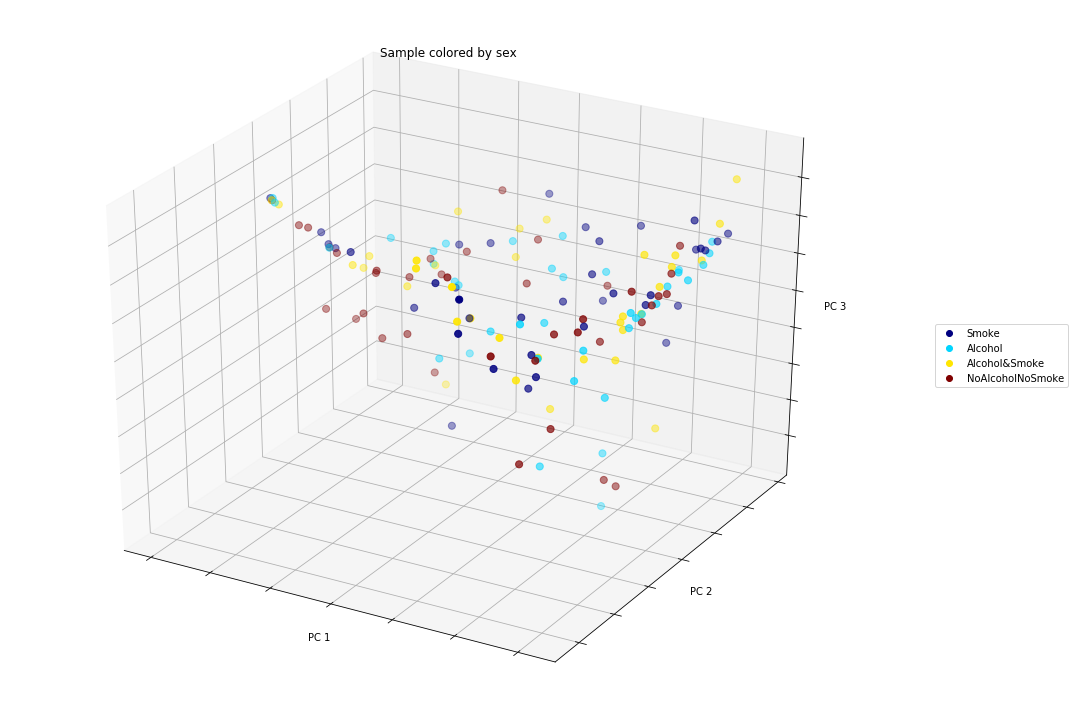

In [50]:
plt.rcParams['figure.figsize'] = [15,10]
fig = wu_pc.plot(sample_md, 'labels',
                  axis_labels=('PC 1', 'PC 2', 'PC 3'),
                  title='Sample colored by sex', cmap='jet', s=50)

Dall'ispezione grafica sembrerebbe di no.

In [59]:
from skbio.stats.distance import anosim, permanova
#results = anosim(wu_dm, sample_md, column='labels', permutations=999)
results = permanova(wu_dm, sample_md, column='labels', permutations=999)
results['test statistic']

1.5199272959255983

In [60]:
results['p-value'] < 0.1

False

Anche i test **anosim** e **permanova** sembrerebbero confermare questa ipotesi, ovvero che la dissimilarità nei gruppi è maggiore rispetto alla dissimilarità tra i gruppi, perciò non vi è una separazione evidente.

In [61]:
sample_md['Observed OTUs'] = adiv_obs_otus
sample_md['Faith PD'] = adiv_faith_pd

Con quest'ultima visualizzazione è possibile verificare, per ogni gruppo, come si distribuiscono i due indici di alpha diversity. Come è possibile verificare nessuna distribuzione è significativamente diversa dalle altre ma si sovrappongono tutte.

Text(0.5, 0, '')

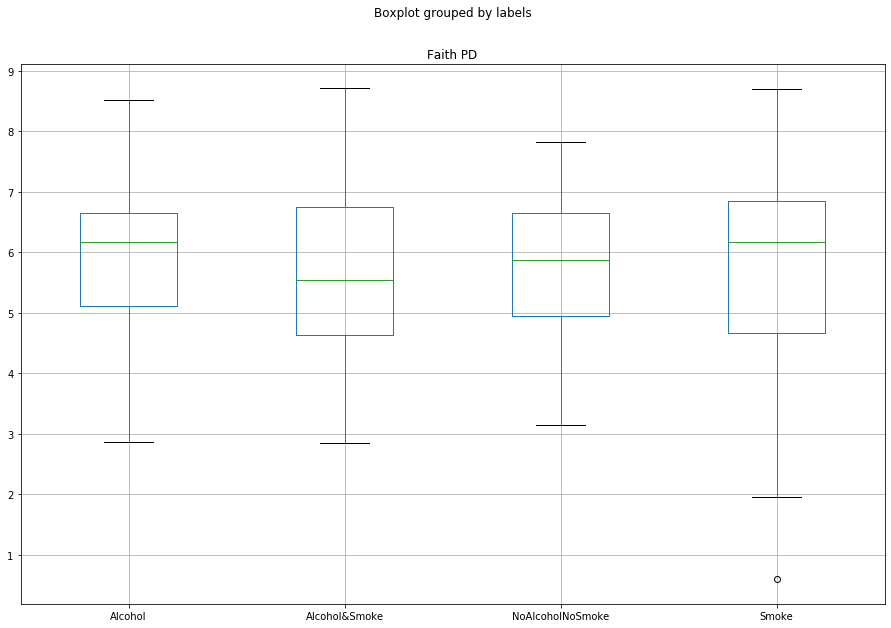

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 8))
plt.close('all') # not necessary for normal use
fig = sample_md.boxplot(column='Faith PD', by='labels')
plt.xlabel('')

Con un test di correlazione di Spearman infine verifichiamo quanto sia forte la correlazione tra i due indici di alpha diversity, ad indicare come l'utilizzo dell'albero filogenetico abbia avuto un basso impatto.

In [58]:
sample_md.corr(method="spearman")

Observed OTUs  Faith PD
Observed OTUs       1.000000  0.974901
Faith PD            0.974901  1.000000

###  Wilcoxon test

In [5]:
df = pd.read_csv('processedData/TreeFeatureTable.csv')

{0:'Alcohol', 1:'Smoke', 2:'Alcohol&Smoke', 3:'NoAlcoholNoSmoke'}

In [6]:
df_taxa = pd.read_csv('processedData/sequences_taxa.csv', index_col='Unnamed: 0')
mapping = {}
for column in df_taxa.columns:
    mapping[df_taxa[column].loc['ncbiID']] = df_taxa[column].loc['species']

In [7]:
df = df.rename(mapping, axis = 1)

In [8]:
df0 = df[df['label'] == 0].drop(['sample_name', 'label'], axis = 1)
df1 = df[df['label'] == 1].drop(['sample_name', 'label'], axis = 1)
df2 = df[df['label'] == 2].drop(['sample_name', 'label'], axis = 1)
df3 = df[df['label'] == 3].drop(['sample_name', 'label'], axis = 1)

In [9]:
from scipy.stats import wilcoxon
from random import sample

In [10]:
df_alc = df[(df['label'] == 0)|(df['label'] == 2)].drop(['sample_name', 'label'], axis = 1)
df_no_alc = df[(df['label'] == 1)|(df['label'] == 3)].drop(['sample_name', 'label'], axis = 1)
df_smk = df[(df['label'] == 1)|(df['label'] == 2)].drop(['sample_name', 'label'], axis = 1)
df_no_smk = df[(df['label'] == 0)|(df['label'] == 3)].drop(['sample_name', 'label'], axis = 1)

In [230]:
def wilcoxon_test(df1, df2, org):
    if len(df1) < len(df2):
        stat, p = wilcoxon(list(df1[org]), sample(list(df2[org]), len(df1)))
    else:
        stat, p = wilcoxon(list(df2[org]), sample(list(df1[org]), len(df2)))
    if (sum(df1[org])/len(df1))>(sum(df2[org])/len(df2)):
        n = 'primo'
    else:
        n = 'secondo'
    print("Il p-value è {} e il gruppo che presenta il maggior numero di batteri {} è il {}".format(
        p, org, n))

In [294]:
def wilcoxon_test_taxa(df1_, df2_, taxa_level, org_name):
    level = list(df_taxa.T[df_taxa.T[taxa_level] == org_name]['species'].value_counts().index)
    df1 = pd.DataFrame(df1_.filter(level).sum(axis = 1)).rename({0:org_name}, axis = 1)
    df2 = pd.DataFrame(df2_.filter(level).sum(axis = 1)).rename({0:org_name}, axis = 1)
    wilcoxon_test(df1, df2, org_name)

##### Alcohol 

Intestinal microbiome alterations in individuals with AUD included depletion of Akkermansia muciniphila and Faecalibacterium prausnitzii and an increase of Enterobacteriaceae. AUD = alcohol use disorder [1]

[1] Changes in the Composition of the Human Intestinal Microbiome in Alcohol Use Disorder: A Systematic Review. Kamil Litwinowicz , Marcin Choroszy , Ewa Waszczuk.

Faecalibacterium prausnitzii:
Faecalibacterium prausnitzii is the most abundant bacterium in the human intestinal microbiota of healthy adults, representing more than 5% of the total bacterial population. Over the past five years, an increasing number of studies have clearly described the importance of this highly metabolically active commensal bacterium as a component of the healthy human microbiota. Changes in the abundance of F. prausnitzii have been linked to dysbiosis in several human disorders. Administration of F. prausnitzii strain A2-165 and its culture supernatant have been shown to protect against 2,4,6-trinitrobenzenesulfonic acid (TNBS)-induced colitis in mice. Here, we discuss the role of F. prausnitzii in balancing immunity in the intestine and the mechanisms involved. [2]

[2] Faecalibacterium prausnitzii and human intestinal health
Author links open overlay panel. S. Miquel, R. Martín.

Non ci sono evidenze nei dati rispetto alla specie 'Faecalibacterium prausnitzii'. 

In [233]:
wilcoxon_test(df_alc, df_no_alc, 'Faecalibacterium prausnitzii')

Il p-value è 0.7560956679731455 e il gruppo che presenta il maggior numero di batteri Faecalibacterium prausnitzii è il primo


Akkermansia muciniphila:
è un batterio che degrada la mucina. La mucina è una glicoproteina presente nei secreti mucosi del tratto respiratorio e gastro-intestinale. "Its abundance in the human intestinal tract is inversely correlated to several disease states." [3]

[3] Akkermansia muciniphila in the Human Gastrointestinal Tract: When, Where, and How?
Sharon Y. Geerlings

I non alcolisti hanno più 'Akkermansia muciniphila' rispetto a chi beve, a conferma di quanto scritto nel paper.

In [241]:
wilcoxon_test(df_alc, df_no_alc, 'Akkermansia muciniphila')

Il p-value è 0.04003938871278547 e il gruppo che presenta il maggior numero di batteri Akkermansia muciniphila è il secondo


Bacteroides fragilis: è presente nel microbioma di tutti i mammifferi. B. fragilis è un “probiotico” con proprietà potenzialmente benefiche per l’organismo: possiede un carboidrato, il polisaccaride A (PSA), con funzione immunomodulatoria, che protegge gli animali da patologie infiammatorie come la colite o la sclerosi multipla.

Drinking frequency was significantly positively correlated with a feeling of incomplete evacuation and counts of the Bacteroides fragilis group. [4]

[4] Association of Life Habits and Fermented Milk Intake With Stool Frequency, Defecatory Symptoms and Intestinal Microbiota in Healthy Japanese Adults. T Shima, & more

Non c'è evidenza nei dati.

In [242]:
wilcoxon_test(df_alc, df_no_alc, 'Bacteroides fragilis')

Il p-value è 0.8479733248680033 e il gruppo che presenta il maggior numero di batteri Bacteroides fragilis è il primo


A lower abundance of Bacteroidetes were found in people who drink frequently. ( Changes in the Composition of the Human Intestinal Microbiome in Alcohol Use Disorder: A Systematic Review. Kamil Litwinowicz , Marcin Choroszy , Ewa Waszczuk.)

In [296]:
wilcoxon_test_taxa(df_alc, df_no_alc, 'phylum','Bacteroidetes')

Il p-value è 0.3571336370971021 e il gruppo che presenta il maggior numero di batteri Bacteroidetes è il primo


#### Smoke 

Pseudomonas aeruginosa: Tra gli agenti eziologici delle polmoniti batteriche lo Pseudomonas aeruginosa è forse il più virulento, per di più scarsamente sensibile ai comuni antibiotici e quindi è causa di un’elevata mortalità.

Non c'è evidenza nei dati.

In [243]:
wilcoxon_test(df_smk, df_no_smk, 'Pseudomonas aeruginosa')

Il p-value è 0.9220543261306254 e il gruppo che presenta il maggior numero di batteri Pseudomonas aeruginosa è il primo


Bacteroidetes: sono un phylum di batteri. E' stato riscontrato che vi sono più bacteroidetes nei fumatori 
- Smoking and the intestinal microbiome - Ziv Savin, Shaye Kivity, Hagith Yonath & Shoenfeld Yehuda).

Non vi è evidenza nei dati

In [244]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'phylum', 'Bacteroidetes')

Il p-value è 0.3775833805011517 e il gruppo che presenta il maggior numero di batteri Bacteroidetes è il primo


Bacteroides: sono un genere di batteri. è stato riscontrato che ve ne sono di più nei fumatori, nei seguenti paper

- Smoking Cessation Alters Intestinal Microbiota: Insights from Quantitative Investigations on Human Fecal Samples Using FISH. Luc Biedermann, MD, Karin Brülisauer, Jonas Zeitz, MD, Pascal Frei, MD, Michael Scharl, MD, PhD, Stephan R. Vavricka, MD, Michael Fried, MD, Martin J. Loessner, PhD, Gerhard Rogler, MD, PhD, Markus Schuppler, PhD

- Smoking and the intestinal microbiome - Ziv Savin, Shaye Kivity, Hagith Yonath & Shoenfeld Yehuda).

Vi è evidenza nei dati.

In [272]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'genus', 'Bacteroides')

Il p-value è 0.08186314787797333 e il gruppo che presenta il maggior numero di batteri Bacteroides è il primo


Clostridium sono un genere di batteri. è stato riscontrato che ve ne sono di più nei fumatori, nei seguenti paper:
- Smoking and the intestinal microbiome - Ziv Savin, Shaye Kivity, Hagith Yonath & Shoenfeld Yehuda).

Non c'è evidenza nei dati.

In [275]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'genus', 'Clostridium')

Il p-value è 0.3386200753832982 e il gruppo che presenta il maggior numero di batteri Clostridium è il primo


On the other hand, Actinobacteria and Firmicutes phyla as well as the genera Bifidobacteria and Lactococcus were decreased. 
- (Smoking and the intestinal microbiome - Ziv Savin, Shaye Kivity, Hagith Yonath & Shoenfeld Yehuda)

Per Actinobacteria i dati dicono il contrario!

In [277]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'phylum', 'Actinobacteria')

Il p-value è 0.018706801913248552 e il gruppo che presenta il maggior numero di batteri Actinobacteria è il primo


Per Firmicutes i dati dicono il contrario!

In [278]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'phylum', 'Firmicutes')

Il p-value è 0.019755038886629855 e il gruppo che presenta il maggior numero di batteri Firmicutes è il primo


Per Lactococcus non ci sono evidenze nei dati

In [281]:
wilcoxon_test_taxa(df_smk, df_no_smk, 'genus', 'Lactococcus')

Il p-value è 0.5150132637387133 e il gruppo che presenta il maggior numero di batteri Lactococcus è il primo
